## Homework 3: Text Classification

### CS 490A, UMass CICS, Fall 2022
### Due: October 5th at 11:59pm. 95 points total.

In this homework, you will design features for and use Logistic Regression models to classify a collection of movie reviews in order to distinguish between positive and negative reviews.

##### How to submit this homework:
Write all the answers in this notebook. Once you are finished, you must submit the following to Gradescope:
1. The generated PDF of your completed notebook
2. Your completed notebook `hw3.ipynb` along with your predictions file `final_predictions.tsv`

## Collaboration Declarations:
List here the name of any classmates that you had high-level discussions with about the homework.

**OPTIONAL: Your declarations here**

## Setup

In [2]:
import numpy as np
import nltk
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from collections import Counter
from scipy.sparse import lil_matrix

nltk.download('punkt')
sns.set(style="white", font_scale=1.3)

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1056)>


## Logistic Regression Implementation

We'll use the following class `LogisticRegression` in this homework assignment. It relies on the scikit-learn implementation. **Do not modify this code.**

In [3]:
######################
#   DO NOT MODIFY!   #
######################
class LogisticRegression:
    """A logistic regression model for text classification."""
    
    def __init__(self, featurizer_method, min_feature_df=1,
                 regularization_inverse_strength=1.0, 
                 ):
        self.feature_index = {}
        self.featurizer_method = featurizer_method
        self.min_feature_df = min_feature_df
        
        self.model = None
        self.regularization_inverse_strength = regularization_inverse_strength
    
    
    def load_data(self, filename):
        """
        This function loads the labels and texts from the input file.
        Texts are converted into bags of features.
        """
        bags_of_feats = []
        labels = []
        with open(filename, encoding="utf-8") as reader:
            for line in reader:
                fields = line.strip().split('\t')
                label = fields[1]
                text = fields[2]
                labels.append(label)
                bags_of_feats.append(self.featurizer_method(text))
        return bags_of_feats, labels

    
    def build_feature_index(self, training_data):
        """
        This function builds the working feature set from the input
        training data and an index over these features (i.e. a mapping
        from features to their numeric indices)
        """
        # Exit early if feature_index already exists 
        if self.feature_index:
            print("WARNING: Feature index already exists")
            return
        
        # Collect the document frequencies for each feature
        feature_dfs = Counter()
        for bag_of_feats in training_data:
            feature_dfs.update(bag_of_feats.keys())
        # Build index
        feat_id = 0
        for feat in feature_dfs:
            if feature_dfs[feat] >= self.min_feature_df:
                self.feature_index[feat] = feat_id
                feat_id += 1

    
    def load_and_process_data(self, filename, isTraining=False):
        """
        This function loads and processes data from the given file.
        It returns the data in a form suitable as input for the underlying
        scikit-learn logistic regression model (self.model).
        """
        bags_of_feats, labels = self.load_data(filename)

        # Build feature index if loading training data
        if isTraining:
            self.build_feature_index(bags_of_feats)
        
        assert self.feature_index, "ERROR: Model has no working features"
        
        # Vectorize bags of features 
        F = len(self.feature_index)
        N = len(bags_of_feats)
        X = lil_matrix((N, F))
        for i, bag_of_feats in enumerate(bags_of_feats):
            for feat, value in bag_of_feats.items():
                if feat in self.feature_index:
                    feat_idx = self.feature_index[feat]
                    X[i, feat_idx] = value
        return X, labels

    
    def train_model(self, filename):
        """
        This function processes the input training file and uses
        this data to train the logistic regression model.
        """
        X, Y = self.load_and_process_data(filename, isTraining=True)
        
        self.model = sklearn.linear_model.LogisticRegression(
                        penalty="l2",
                        C=self.regularization_inverse_strength,
                        solver='liblinear'
                        )
        self.model.fit(X, Y)
    
    
    def print_weights(self, display_k=5):
        """
        This function prints the top feature weights for each label class.
        """
        assert self.model, "ERROR: Must train model first"

        reverse_feature_idx = {idx:feat for feat, idx in self.feature_index.items()}        
        
        weights = self.model.coef_[0]
        sorted_idx = np.argsort(weights)
        
        label = self.model.classes_[1]
        for i in sorted_idx[-display_k:][::-1]:
            weight = weights[i]
            if weight <= 0:
                continue
            feat = reverse_feature_idx[i]
            print("{}\t{}\t{:.2f}".format(label, feat, weight))
        print()
        
        label = self.model.classes_[0]
        for i in sorted_idx[:display_k]:
            weight = weights[i]
            if weight >= 0:
                continue
            feat = reverse_feature_idx[i]
            print("{}\t{}\t{:.2f}".format(label, feat, weight))
        
    
    def evaluate_classifier_accuracy(self, filename):
        """
        This function computes the model accuracy for the data in the input file.
        """
        assert self.model, "ERROR: Must train model first"
        
        X, Y = self.load_and_process_data(filename)
        accuracy = self.model.score(X, Y)
        return accuracy
        
    
    def predict(self, filename, includeClassProbs=False):
        """
        Returns the model predictions for the data in the input file
        and optionally the estimated class probabilities
        """
        assert self.model, "ERROR: Must train model first"
        
        X, Y = self.load_and_process_data(filename)
        predictions = self.model.predict(X)
        
        # Optionally return the estimated class probabilities too
        if includeClassProbs:
            probs = self.model.predict_proba(X)
            return predictions, probs
        
        return predictions

## I. Getting Started (15 pts)
Since Logisitic Regression does not require its *features* to be independent (unlike Naive Bayes), our working features for text classification can go well beyond word counts. In this assignment, we will transform our texts into *bags of features* which we will use as input for our classifiers.

To begin, let's use simple dictionary-based features. If a review contains the word *love*, *great*, or *fantastic*, then we'll set the `contains_positive_term` feature to 1. Similarly, if a review contains the word *hate*, *terrible*, or *dreadful*, then we'll set the `contains_negative_term` feature to 1.

In [4]:
def simple_featurizer(text):
    feats = {}
    tokens = nltk.word_tokenize(text.lower())
    
    for token in tokens:
        if token in ["love", "great", "fantastic"]:
            feats["contains_positive_term"] = 1
        if token in ["hate", "terrible", "dreadful"]:
            feats["contains_negative_term"] = 1
    return feats

Now that we have a method for converting texts to bags of features, we can build a classifier using the provided `LogisticRegression` class.

Similar to Homework 2's `NaiveBayes` class, we must initialize our classifier before we can train it. For initialization, the `LogisticRegression` class requires a method for converting texts into bags of features. This class has several *optional* inputs, we'll cover them later on in this assignment.

Let's use our `simple_featurizer` featurizer to create a Logistic Regression classifier and train it using the training data in `train.tsv`.

In [5]:
simple_classifier = LogisticRegression(simple_featurizer)
simple_classifier.train_model("train.tsv")

We can then evaluate this classifier by computing the accuracy for our training set and our validation set in `dev.tsv`.

In [6]:
print("Training Accuracy: {:.3f}".format(simple_classifier.evaluate_classifier_accuracy("train.tsv")))
print("Validation Accuracy: {:.3f}".format(simple_classifier.evaluate_classifier_accuracy("dev.tsv")))

Training Accuracy: 0.624
Validation Accuracy: 0.610


We've provided the following method `evaluate_classifier` to output several useful properties of a *trained* classifier:
- the name of its featurizer method
- the number of working features
- its accuracy for our training set
- its accuracy for our validation set

In [7]:
######################
#   DO NOT MODIFY!   #
######################
def evaluate_classifier(classifier):
    """
    Evaluates a trained classifier
    """
    train_acc = classifier.evaluate_classifier_accuracy("train.tsv")
    dev_acc = classifier.evaluate_classifier_accuracy("dev.tsv")
    featurizer_name = classifier.featurizer_method.__name__
    n_features = len(classifier.feature_index)
    print("Featurizer: {}, # Features: {}".format(featurizer_name, n_features))
    print("Training Accuracy: {:.1f}%, Validation Accuracy: {:.1f}%".format(train_acc*100 ,dev_acc*100))

In [8]:
evaluate_classifier(simple_classifier)

Featurizer: simple_featurizer, # Features: 2
Training Accuracy: 62.4%, Validation Accuracy: 61.0%


Although an accuracy of 60% does not seem particularly high, it's worth comparing this performance with a simple baseline, namely the "choose majority" classifier. As the name suggests, this classifier once trained returns a single label no matter the input. This label is chosen by determining the most frequent label class according to the labels seen during training.

**Question 1.1 (5 pts)**

Take a look at the labels of our training and validation sets (i.e., the second column of each .tsv). Assume we train the "choose majority" classifier using our training set, what will be this classifier's accuracy for both the training and validation sets? How does it compare to the accuracies we got using `simple_featurizer`?

**Your answer here**  
If we train the "choose majority", our model will be more likely to predict the majority case will predicting testing set. In this way, the biased model will have a lower perform.  
For comparing to the accuracies, it will have a higher training accuracy but lower validation accuracy while testing by a 50/50 labled test dataset.

The `LogisticRegression` class has a method `print_weights` that prints the top weights for each of our classes: *pos* and *neg*. The optional parameter `display_k` can be used to specify the number of weights to be printed for each class.

In [9]:
simple_classifier.print_weights()

pos	contains_positive_term	1.00

neg	contains_negative_term	-1.54


**Question 1.2 (5 pts)**

The above output only prints two weights, one for each class. Why is this? Make sure to explain your reasoning.

**Your answer here**  
In simple_featurizer, there is only contains_positive_term and contains_negative_term these 2 feats, so we only have 1 feat for each class and thats why only prints two weights. 

**Question 1.3 (5 pts)**

What does the output of `print_weights` tell us about the features of `simple_featurizer`?

**Your answer here**  
It tells us that lable positive have a feat named contains_positive_term which weight 1.00 and lable negative have a feat contains_negative_term which weight -1.54. So simple_featurizer have 2 feats and the negative term have more weights than positive term. 

## II. Bag of Words (20 pts)
Now, let's build a new featurizer method that converts a text into a *binary* bag of words (i.e. there is a feature for each observed word type and its value is set to 1).

**Question 2.1 (5 pts)**

Complete the implementation of `bag_of_words` so that it returns a *dictonary* (`dict`) of feature-value pairs corresponding to the text's binary bag of words.

In [42]:
def bag_of_words(text):
    """
    This method returns a binary bag of words representation of a text
    
    The return dict `feats` must have the following form:
    - keys correspond to the name of the feature
    - values correspond to the feature's value
    
    """ 
    feats = {}
    tokens = nltk.word_tokenize(text.lower())
    
    # Your code here
    for token in tokens:
        if token not in feats:
            feats[token] = 1
    
    return feats

With `bag_of_words` implemented, we can see how well these features work for our classification task.

In [12]:
bow_classifier = LogisticRegression(bag_of_words)
bow_classifier.train_model("train.tsv")
evaluate_classifier(bow_classifier)

Featurizer: bag_of_words, # Features: 40970
Training Accuracy: 100.0%, Validation Accuracy: 84.7%


Unlike our first classifier (`simple_classifier`), our bag of words classifier (`bow_classifier`) has a dramatically higher training accuracy than validation accuracy. Moreover, our classifier reaches perfect accuracy. 

**Question 2.2 (5 pts)**

Why is the training accuracy so high? Explain your reasoning.  

**Your answer here**  
The bow_classifier is performing much better than simple_classifier since it is basically make vocabulary into a dictionary, and compare the testing data with existing training set. In this way, it transfer the language into a vector. In this way, our training accuracy will be very high since we trained with it and we have all these vectors in our model already. While testing, there might be some new words that is not in the vocab dictionary, which affect the validation accuracy to be lower than training one. 

The `LogisticRegression` class includes two ways to reduce overfitting.

Firstly, the parameter `min_feature_df` specifies the minimum number of documents a feature must appear in during training to be considered a feature for the model. This is especially helpful for bag of words style features whose presence depends on the texts seen during training.

Secondly, our model uses L2 regularization. We can specify the strength of the L2 regularization with the `regularization_inverse_strength` parameter. This parameter must be a positive value. Smaller values correspond to stronger regularization, while larger values correspond to weaker regularization.

**Question 2.3 (5 pts)**

Let's examine the effects of `regularization_inverse_strength`. As the value of `regularization_inverse_strength` decreases, how do the weights and accuracies of the bag of words classifier change?

In [13]:
for inv_str in [1.0, 0.1, 1e-3]:
    print("regularization_inverse_strength = {}".format(inv_str))
    model = LogisticRegression(bag_of_words, regularization_inverse_strength=inv_str)
    model.train_model("train.tsv")
    evaluate_classifier(model)
    model.print_weights()
    print()

regularization_inverse_strength = 1.0
Featurizer: bag_of_words, # Features: 40970
Training Accuracy: 100.0%, Validation Accuracy: 84.7%
pos	great	1.27
pos	entertaining	1.08
pos	7/10	1.02
pos	realistic	0.97
pos	superb	0.93

neg	worst	-2.23
neg	waste	-1.37
neg	awful	-1.37
neg	boring	-1.26
neg	bad	-1.21

regularization_inverse_strength = 0.1
Featurizer: bag_of_words, # Features: 40970
Training Accuracy: 99.2%, Validation Accuracy: 84.9%
pos	great	0.82
pos	entertaining	0.56
pos	excellent	0.52
pos	love	0.51
pos	perfect	0.50

neg	worst	-1.24
neg	bad	-0.79
neg	awful	-0.74
neg	waste	-0.74
neg	boring	-0.70

regularization_inverse_strength = 0.001
Featurizer: bag_of_words, # Features: 40970
Training Accuracy: 84.8%, Validation Accuracy: 80.5%
pos	great	0.13
pos	love	0.08
pos	best	0.07
pos	well	0.07
pos	also	0.06

neg	bad	-0.15
neg	worst	-0.11
neg	?	-0.10
neg	no	-0.09
neg	even	-0.08



**Your answer here.**   
For lowering the regularization_inverse_strength from 1.0 to 0.1, feats printed out for both pos and neg lable are having lower weight since it wants to prevent overfitting. Also, 7/10 appears on feat for regularization_inverse_strength=1.0 which it does not mean any pos or neg to me, it might just be a number frequently appear in the pos lable's training set. Also, the training accuracy and validation accuracy does not change a lot in this case.  
For lowering the regularization_inverse_strength from 0.1 to 0.01, feats printed out for both pos and neg lable are having lower weight since it wants to prevent overfitting. However, since the weight for each feats are too low, it is having negative impact on our result. Both training accuracy and validation accuracy drops. This might because this too low weights, it make our model difficult to compare these vectors transformed by the dataset in words. For example, while regularization_inverse_strength=0.1, the biggest difference between weights of pos and neg is 0.82-(-1.24) = 2.06; while regularization_inverse_strength=0.01, the biggest difference between weights of pos and neg is 0.13-(-0.15) = 0.28 which is much smaller than before which result the accuracy drop.

**Question 2.4 (5 pts)**

Now, try improving the general performance (i.e. validation accuracy) of your bag of words classifier by changing both the `regularization_inverse_strength` and `min_feature_df` parameters in the cell below.

*Note there is no single "right" answer for this question.*

In [28]:
# Only modify the regularization_inverse_strength and min_feature_df parameters
final_bow_classifier = LogisticRegression(bag_of_words,
                                          regularization_inverse_strength=0.2,
                                          min_feature_df = 3)

In [29]:
######################
#   DO NOT MODIFY!   #
######################
final_bow_classifier.train_model("train.tsv")
evaluate_classifier(final_bow_classifier)

Featurizer: bag_of_words, # Features: 14651
Training Accuracy: 99.6%, Validation Accuracy: 85.0%


## III. Designing Features (50 pts)

In this core part of the assignment, you will design *three* additional classes of features. For each class you will: (1) describe its features, (2) justify why you believe these features *should* perform better than a bag of words, (3) implement the corresponding featurizer, and (4) evaluate the performance of a logistic regression classifier that relies on these features. *These classes of features must be distinct*.

The most creative features will receive extra credit for this assignment (up to 10 points). For evaluating extra credit, we will consider the uniqueness of the features (relative to other student submissions), the quality of their written descriptions and justification, and the performance of these features.

### 3.1 Feature 1 (15 points)

**Question 3.1.1**

In a few sentences, describe this class of features and explain why you believe that these features will perform better than a bag of words for our task.

**Your answer here**  
My feat1 is basically an improvement of bag_of_words plus an stopwords remove. Since we have not consider words such as 'our', 'i', 'the' words like this which does not provide information about pos and neg. In this way, we remove them from our dictionary return so that this would increse the prediction performance.

**Question 3.1.2**

Implement the featurizer for this class of features in the following cell. Then, train a classifier that relies on this featurizer in the cell after that. Tailor the values for `regularization_inverse_strength` and `min_feature_df` to suit this feature representation.

In [110]:
from nltk.corpus import stopwords
def feat1(text):
    """
    This method returns a bag of features
    
    The return dict `feats` must have the following form:
    - keys correspond to the name of the feature
    - values correspond to the feature's value
    
    """ 
    feats = {}
    
    # Your code here
    avoid = stopwords.words('english')
    tokens = nltk.word_tokenize(text.lower())
    for token in tokens:
        if token in avoid:
            continue
        if token not in feats:
            feats[token] = 1
    
    return feats

In [115]:
# Only modify the regularization_inverse_strength and min_feature_df parameters
feat1_classifier = LogisticRegression(feat1,
                                      regularization_inverse_strength=0.1,
                                      min_feature_df = 2)

In [116]:
######################
#   DO NOT MODIFY!   #
######################
feat1_classifier.train_model("train.tsv")
evaluate_classifier(feat1_classifier)

Featurizer: feat1, # Features: 20065
Training Accuracy: 98.8%, Validation Accuracy: 85.2%


As we see on the result printed out, both accuracy are better than the question2.4, althogh it is just improved by a little, it is still a progress I think.

### 3.2 Feature 2 (15 points)

**Question 3.2.1**

In a few sentences, describe this class of features and explain why you believe that these features will perform better than a bag of words for our task.

**Your answer here**  
This feat2 is basically same as bag of words. But I avoid the word with too short and I give different word with different weight in dictionary feats. If the word appearing more than 1 time, it will have a weight up to 5.  
I believe these feature will perform better than a bag of words since word that is too short are meaning less in most cases, such as 'I', 'a', 'an', 'of' or other words like these. Also, if we assign more weight to a word such as 'good' which always show up in the pos case, it will help us to have a better prediction.

**Question 3.3.2**

Implement the featurizer for this class of features in the following cell. Then, train a classifier that relies on this featurizer in the cell after that. Tailor the values for `regularization_inverse_strength` and `min_feature_df` to suit this feature representation.

In [83]:
def feat2(text):
    """
    This method returns a bag of features
    
    The return dict `feats` must have the following form:
    - keys correspond to the name of the feature
    - values correspond to the feature's value
    
    """ 
    feats = {}
    
    # Your code here
    tokens = nltk.word_tokenize(text.lower())
    for token in tokens:
        if len(token)>2:
            if token not in feats:
                feats[token] = 1
            else:
                feats[token] +=1
    
    for feat in feats:
        if feats[feat]>5:
            feats[feat]=5
    
    return feats

In [84]:
# Only modify the regularization_inverse_strength and min_feature_df parameters
feat2_classifier = LogisticRegression(feat2,
                                      regularization_inverse_strength=0.15,
                                      min_feature_df = 3)

In [85]:
######################
#   DO NOT MODIFY!   #
######################
feat2_classifier.train_model("train.tsv")
evaluate_classifier(feat2_classifier)

Featurizer: feat2, # Features: 14369
Training Accuracy: 99.4%, Validation Accuracy: 85.9%


### 3.3 Feature 3 (15 points)

**Question 3.3.1**

In a few sentences, describe this class of features and explain why you believe that these features will perform better than a bag of words for our task.

**Your answer here**  
This feat2 is basically same as bag of words. But I avoid the word with too short and I give different word with different weight in dictionary feats. In addition, words appearing too much in all training datasets, maybe meaningless for determine pos and neg, so I convert their weight into 1/weight so that this could reduce missleading while predict.
I believe these feature will perform better than a bag of words since word that is too short are meaning less in most cases, such as 'I', 'a', 'an', 'of' or other words like these. Also, the 1/weight also helps for prediction.

**Question 3.3.2**

Implement the featurizer for this class of features in the following cell. Then, train a classifier that relies on this featurizer in the cell after that. Tailor the values for `regularization_inverse_strength` and `min_feature_df` to suit this feature representation.

In [101]:
def feat3(text):
    """
    This method returns a bag of features
    
    The return dict `feats` must have the following form:
    - keys correspond to the name of the feature
    - values correspond to the feature's value
    
    """ 
    feats = {}
    tokens = nltk.word_tokenize(text.lower())
    for token in tokens:
        if len(token)>2:
            if token not in feats:
                feats[token] = 1
            else:
                feats[token] +=1
    
    for feat in feats:
        if feats[feat]>10:
            feats[feat] = 1/feats[feat]
    
    return feats

In [104]:
# Only modify the regularization_inverse_strength and min_feature_df parameters
feat3_classifier = LogisticRegression(feat3,
                                      regularization_inverse_strength=0.2,
                                      min_feature_df = 3)

In [105]:
######################
#   DO NOT MODIFY!   #
######################
feat3_classifier.train_model("train.tsv")
evaluate_classifier(feat3_classifier)

Featurizer: feat3, # Features: 14369
Training Accuracy: 99.7%, Validation Accuracy: 85.9%


### 3.4 Comparing Features

**Question 3.4 (5 points)** Now, compile the results for the classifiers that you have built using each of these features as well as your bag of words features from Part II. Add these results to the table below. Then, comment on these results. Which of these features were the best and worst performers? Were these results surprising? Explain your reasoning.

| Feature | # Features | Training Accuracy | Validation Accuracy |
| :- | -: | -: | -: |
| Bag of Words | A dictionary that contain all vocab|99.6% | 85.2%|
| Feature 1 | A dictionary that contain all vocab without the word meaningless in the top feat of bag_of_word| 99.6%| 85.3%|
| Feature 2 | A dictionary that contain all vocab in different weight without words that are too short|99.4% | 85.9%|
| Feature 3 | A dictionary that contain all vocab in different weight without words that are too short and if one feat appears too much, lower its weight in dict feats| 99.5%| 85.9%|

**Your answer here**

## IV. Combining Features (10 pts)
And finally, you'll creating an ultimate feature reprensentation in order to make predictions for our test set in `test.tsv`.

**Question 4.1 (5 points)**

Implement `final_features` so that it produces a feature representation that is a combination of any and all of the features that you have developed through the course of this assignment (i.e., `bag_of_words`, `feat1`, `feat2`, and `feat3`). *Your code must directly call these previously implemented featurizer methods.*

Then, train a classifier that relies on `final_features` in the cell after that. Tailor the values for `regularization_inverse_strength` and `min_feature_df` to suit your class of features.

In [125]:
def final_features(text):
    """
    This method returns a bag of features
    
    The return dict `feats` must have the following form:
    - keys correspond to the name of the feature
    - values correspond to the feature's value
    
    """ 
    feats = {}
    
    # Your code here
    avoid = stopwords.words('english')
    tokens = nltk.word_tokenize(text.lower())
    for token in tokens:
        if len(token)>2:
            if token in avoid:
                continue
            elif token not in feats:
                feats[token] = 1
            else:
                feats[token] +=1
    
    for feat in feats:
        if feats[feat]>10:
            feats[feat] = 1/feats[feat]
        if feats[feat]>5:
            feats[feat]=5
    
    return feats

In [130]:
# Only modify the regularization_inverse_strength and min_feature_df parameters
final_classifier = LogisticRegression(final_features,
                                      regularization_inverse_strength=0.1,
                                      min_feature_df = 3)
#final_classifier.train_model("train.tsv")
#evaluate_classifier(final_classifier)

Featurizer: final_features, # Features: 14267
Training Accuracy: 99.1%, Validation Accuracy: 85.8%


**Question 4.2 (5 points)**

Finally run the following code cell to make predictions for our test set and save them to the file `final_predictions.tsv`. Upload this file as part of your code submission to Gradescope.

The five systems with the highest performance will receive 5 points of extra credit for this assignment. 

In [132]:
######################
#   DO NOT MODIFY!   #
######################
final_classifier.train_model("train.tsv")
predictions = final_classifier.predict("test.tsv")

with open("final_predictions.tsv", mode="w", encoding="utf-8") as writer:
    with open("test.tsv", encoding="utf-8") as reader:
        for i, line in enumerate(reader):
            review_id = line.split('\t')[0]
            writer.write("{}\t{}\n".format(review_id, predictions[i]))

## Resource: Analyzing Classifiers

In this section, we will go over a few methods for analyzing classifiers. You may find these methods useful for identifying ways to improve the performance of your classifiers. **Nothing in this section will be graded.** Consider these as tools that you might use to support the design of your feature representations in Parts III and IV.

### Confusion matrices

We can examine the confusion matrix for a model's predictions. Are certain mistakes more likely than others? (Note that this tends to be more useful in multi-class classification rather than binary classification)

In [133]:
def load_labels(filename):
    labels = []
    with open(filename, encoding="utf-8") as reader:
        for line in reader:
            label = line.split('\t')[1]
            labels.append(label)
    return labels

def view_confusion_matrix(classifier, filename):
    # Get true and predicted labels
    true_labels = load_labels(filename)
    predictions = classifier.predict(filename)
    
    sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
        true_labels, predictions, labels=["pos", "neg"],
        cmap=plt.cm.Purples)

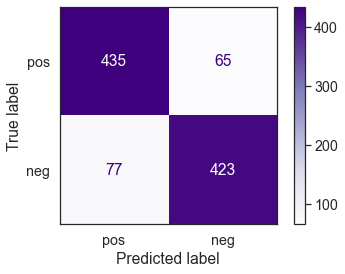

In [134]:
view_confusion_matrix(final_classifier, "dev.tsv")

### Most defining features

Next, we can examine the most defining features for each label class by looking at the weights of our model, specifically the ones with the highest magnitudes. Are your proposed features helping in the way that you expect? Do successful features suggest others? What features might provide a complementary view of the reviews and their sentiments?

In [135]:
final_classifier.print_weights(display_k=25)

pos	entertaining	0.59
pos	great	0.59
pos	superb	0.54
pos	excellent	0.54
pos	enjoy	0.46
pos	realistic	0.45
pos	definitely	0.45
pos	perfect	0.44
pos	highly	0.43
pos	favorite	0.42
pos	wonderful	0.41
pos	best	0.41
pos	hilarious	0.40
pos	sometimes	0.40
pos	tony	0.40
pos	enjoyed	0.39
pos	today	0.39
pos	amazing	0.38
pos	human	0.38
pos	fun	0.38
pos	mad	0.37
pos	8/10	0.37
pos	especially	0.36
pos	love	0.36
pos	powerful	0.36

neg	worst	-1.13
neg	waste	-0.77
neg	awful	-0.70
neg	boring	-0.65
neg	bad	-0.62
neg	worse	-0.60
neg	nothing	-0.59
neg	terrible	-0.56
neg	unfortunately	-0.51
neg	wonder	-0.50
neg	attempt	-0.49
neg	money	-0.49
neg	horrible	-0.46
neg	instead	-0.46
neg	poor	-0.46
neg	dull	-0.45
neg	avoid	-0.43
neg	mess	-0.42
neg	save	-0.41
neg	guess	-0.40
neg	painful	-0.40
neg	supposed	-0.39
neg	idea	-0.38
neg	lame	-0.38
neg	unless	-0.37


### Examining the most confident mistakes

Finally, we can examine the reviews that the model gets most wrong. We can quantify "most wrong" as the misclassified reviews with the largest estimated probabilities $\Pr(incorrect\_label \mid review)$. Do these examples suggest any features that might correct these mistakes?

In [136]:
def print_mistakes(classifier, filename, display_k=10):
    true_labels = load_labels(filename)
    predictions, est_probs = classifier.predict(filename, includeClassProbs=True)
    
    class_index = {}
    for i, label in enumerate(classifier.model.classes_):
        class_index[label] = i
    
    mistakes = []
    with open(filename, encoding='utf-8') as reader:
        for i, line in enumerate(reader):
            if predictions[i] != true_labels[i]:
                fields = line.strip().split('\t')
                mistake = {
                    "review_id": fields[0],
                    "true_label": true_labels[i],
                    "pred_label": predictions[i],
                    "prob": est_probs[i][class_index[predictions[i]]],
                    "review": fields[2]
                }
                mistakes.append(mistake)
    
    df = pd.DataFrame(mistakes)
    with pd.option_context('display.max_colwidth', 300):
        display(df.nlargest(display_k, "prob"))

In [137]:
print_mistakes(final_classifier, "dev.tsv")

,review_id,true_label,pred_label,prob,review
99,10155,neg,pos,0.994444,"I have read several good reviews that have defended and critised the various aspects of this film. One thing I see, over and over, is annoyance with Megan, the idealistic political scientist, trying to change the world. I loved her character. Maybe, because I am a 23 year old political science s..."
57,1293,neg,pos,0.989012,"I am probably one of the few viewers who would not recommend this film. Thought visually stunning like all of Ang Lee's work (each still frame seems worthy of a print), I was really disappointed by the film's disjointed pace. It really was too long. The story is set in Civil War era Missouri, an..."
111,12312,neg,pos,0.974667,"For 50 years after world war 2 the United States was in a state where key segments of the economy were dominated by military interests. At the same time, because of the draft and wars, everyone in society had served, or was connected to someone who had. This allowed for a minigenre based on the ..."
68,2534,pos,neg,0.973286,"Scientist working frantically in seclusion finds a way to locate the impact crater of a meteor carrying a new radioactive element. All (pseudo)science and breakthrough technology talks of the 1930s are right there, including the idea that radioactivity could heal any illness if properly harnesse..."
93,9242,pos,neg,0.969170,"It's hard to rate films like this, because do you rate it on production or just fun? I saw this film back in about 1988/89 or so when I was a boy and I'm sorry to say it started a life long fascination with ninjas. The plot is fairly dire and the acting is of course terrible, but there is a cert..."
54,2934,neg,pos,0.962634,"Simon Pegg stars as Sidney Young, a stereotypically clumsy idiot Brit working as a celebrity journalist in this US comedy. After getting a very lucky break he starts work at the highly respected Sharps magazine run by a reliably on form Jeff Bridges in New York. It's more The Devil Wears Prada t..."
18,5486,pos,neg,0.960153,"Yes, the cameras were in the right place at the right time. It's so interesting to see how a world leader (like Chavez) who supports the poor people in his country, can be held in such low esteem in the US. His worst ""sin"", in my opinion, is caring about those who are at the bottom of the barrel..."
7,4805,neg,pos,0.956129,"I loved Adrianne Curry before this show. I thought she was great on Top Model and was really glad when she won. I also liked Chris Knight, he seems like a great guy. But this show just made me SICK! I'm so angry at both of them for what happened on that show. I don't care that they were differen..."
94,10559,pos,neg,0.951975,"I haven't written a review on IMDb for the longest time, however, I felt myself compelled to write this! When looking up this movie I found one particular review which urged people NOT to see this film. Do not pay any attention to this ignorant person! NOTHING is a fantastic film, full of laughs..."
125,4605,neg,pos,0.946230,"This movie is written by Charlie Higson, who has before this done the ""legendary"" Fast Show and his own show based on one of Fast Show's characters (Tony the car sales man). He's also written James Bond books for kids. Actually I've seen before this only Gordon's movies that are based on Lovecra..."
